# Binær klassifisering ved hjelp av et nevralt nettverk

## Introduksjon

I denne oppgaven skal det utføres en binær klassifisering av ulike typer bilder. Modellen som skal brukes er et nevralt nettverk med en forholdsvis beskjeden dybde. 
$\color{red}{Mer \, spesifikt \, om \, hvordan \, modellen \, er \, bygget \, opp?}$

Tilnærmingen til problemet er todelt: 
* En treningsfase der parametrene assosiert med hver transformasjon som gir lavest mulig avvik finnes. Avviket beregnes ved hjelp av en kostfunksjon,som benytter seg av et sett med labels. Dette er essensielt en liste over de ulike punktenes reelle binære klassifisering, slik at modellen sin klassifisering kan sammenlignes med denne. 
* En valideringsfase der bilder som ikke ble brukt i treningsfasen transformeres med parameterne som ble funnet. Herfra kan man trekke en konklusjon om modellen klassifiserer bildene på en god måte eller ikke. 

I testproblem 1 skal punkter i planet klassifiseres. Det skal skilles mellom to typer punkter. Her er de valgt til å være henholdsvis røde og blå. "Bildet" i dette problemet er et punkt, kun beskrevet av to koordinater $(x,y)$. Modellen skal dermed trenes til å avgjøre om et vilkårlig punkt er rødt eller blått.

I testproblem 2 skal siffer fra MNIST klassifiseres. Her er det snakk om virkelige bilder med lav oppløsning. Størrelsen på bildene er 28 x 28 piksler. Bildene i settene fra MNIST består av siffer fra 0-9, dvs 10 ulike klasser av bilder. For at dette skal passe inn i vår binære klassifiseringsmodell holder vi oss til kun to forskjellige siffer, som for eksempel 2 og 7. 


## Oversikt over funksjoner


In [55]:
import numpy as np
import matplotlib.pyplot as plt
from spirals import*
from plotting import* 
from loader import*
import pickle

def sigma(x):
    return np.tanh(x)

def sigma_der(x):
    return 1-(np.tanh(x))**2  

def eta(x):
    return 0.5*(1+sigma(x/2))

def eta_der(x):
    return 0.25*sigma_der(x/2)    

def adam_method(x, x_der, m_jn, v_jn, j):
    beta_1 = 0.9
    beta_2 = 0.999
    alfa = 0.01
    epsilon = 1e-8
    m_j = beta_1*m_jn + (1-beta_1)*x_der
    v_j = beta_2*v_jn + (1-beta_2)* (x_der*x_der)
    m_hatt_j = m_j/(1-beta_1**(j))
    v_hatt_j = v_j/(1-beta_2**(j))
    val = alfa*m_hatt_j/(np.sqrt(v_hatt_j) + epsilon)
    x -= val
    return x, m_j, v_j

def set_random_parameters(K, d):
    ''' W_k er en dxd matrise og  (2x2 for leketøysmodellen)
        b_k er en dx1 vektor elementer for hver k  (2x1 for leketøysmodellen)
    ''' 
    W_k = np.random.randn(K,d,d)
    b_k = np.random.randn(K,d,1)  
    omega = np.random.randn(d)     
    my = np.random.rand() 
    return W_k, b_k, omega, my

def initialize(K,d,I):
    Y_Kk = np.zeros((K+1,d,I))
    b_k_dim = np.zeros((K,d,I))  #Kunne vi holdt oss med å lage én b_k? Nå virker det litt kaotisk 
    J_der_W = np.zeros((K,d,d))
    J_der_b = np.zeros((K,d,1))
    vec_I = np.ones((I,1))  #For matrisemultiplikasjon
    P_Kk = np.zeros((K,d,I)) 
    return Y_Kk, b_k_dim, J_der_W, J_der_b, vec_I, P_Kk

def stochastic_gradient_descent(Y_0, C, I_tot, chunk): 
    ''' Made to pick out pictures to test. Modifies the Adam Descent Algorithm. ''' 
    start = np.random.randint(I_tot-chunk)
    Y0_chunk = Y_0[:,start:start+chunk] 
    C_chunk = C[start:start+chunk]
    return Y0_chunk, C_chunk 

def calculate_YKk_and_Z(my, omega, b_k, W_k, Y_Kk, b_k_dim, h, K):
    for i in range(K):
        b_k_dim[i,:,:] = b_k[i,:,:]    #Lager I kolonner med b_k[i], for at dimensjonen skal passe ved addisjon under
        Y_Kk[i+1] = Y_Kk[i] + h*sigma(W_k[i] @ Y_Kk[i] + b_k_dim[i]) 
    
    Z = eta(np.transpose(Y_Kk[-1]) @ omega + my)  
    return Y_Kk, b_k_dim, Z

def calculate_projection_derivatives(my, omega, Y_Kk, Z, c):
    ''' Calculates parts of gradient (5) and (6) '''
    YT_k = np.transpose(Y_Kk[-1])  #Kunne fjernet denne og satt den inn i lignene nedenfor kanskje?
   
    J_der_my = np.transpose(eta_der(YT_k @ omega + my)) @ (Z-c) 
    J_der_omega = Y_Kk[-1] @ ((Z-c) * eta_der(YT_k @ omega + my))
    return J_der_my, J_der_omega

def calculate_rest_of_gradient(my, omega, b_k_dim, W_k, Y_Kk, Z, c, h, K, P_Kk, J_der_W, J_der_b, vec_I):
    ''' Calculates P_(k-1) from (8) '''
    YT_k = np.transpose(Y_Kk[-1])   #Kunne fjernet denne og satt den inn i lignene nedenfor kanskje?
    P_k = np.outer(omega,(Z-c)*eta_der(YT_k @ omega + my))
    P_Kk[-1] = P_k      

    for i in range(K-1,0,-1):  #Starter på P_k(=indeks K-1) og helt til og med P_1(=indeks 0)
        P_Kk[i-1] = P_Kk[i] + h*np.transpose(W_k[i-1]) @ (sigma_der(W_k[i-1] @ Y_Kk[i-1] +b_k_dim[i-1]) * P_Kk[i])
    
    for i in range(K):
        val = P_Kk[i] * sigma_der(W_k[i] @ Y_Kk[i] + b_k_dim[i])
        J_der_W[i] = h*(val @ np.transpose(Y_Kk[i]))
        J_der_b[i] = h*(val @ vec_I)
        
    return J_der_W, J_der_b

#Er det nødvendig å ta med alle konstanter i parameterlistene?
def algorithm(Y_0, c, K, d, iterations, h, I, chunk): 
    
    W_k, b_k, omega, my = set_random_parameters(K, d)
    
    j = 1
    J = np.zeros(iterations)
    
    stocastic_method = False
    if chunk < I: # then use Stocastic method
        I_tot = I  #new variable name
        I = chunk  #to get right dimensions below
        Y_0_tot = Y_0
        c_tot = c
        stocastic_method = True
    
    Y_Kk, b_k_dim, J_der_W, J_der_b, vec_I, P_Kk = initialize(K, d, I)
    
    #Til Adam-metoden:
    v_j = np.array([0,np.zeros(d),np.zeros((K,d,1)),np.zeros((K,d,d))])
    m_j = np.array([0,np.zeros(d),np.zeros((K,d,1)),np.zeros((K,d,d))])
    
    while j <= iterations:
        if stocastic_method:
            Y_0, c = stochastic_gradient_descent(Y_0_tot, c_tot, I_tot, chunk)
        
        Y_Kk[0] = Y_0
        Y_Kk, b_k_dim, Z = calculate_YKk_and_Z(my, omega, b_k, W_k, Y_Kk, b_k_dim, h, K) #Makes new Y_Kk and b_k_dim
        
        J[j-1] = 0.5*np.linalg.norm(Z-c)**2
        
        J_der_my, J_der_omega = calculate_projection_derivatives(my, omega, Y_Kk, Z, c) 
        
        J_der_W, J_der_b = calculate_rest_of_gradient(my, omega, b_k_dim, W_k, Y_Kk, Z, c, h, K, P_Kk, J_der_W, J_der_b, vec_I)
        
        my, m_j[0],v_j[0] = adam_method(my, J_der_my, m_j[0], v_j[0], j)
        omega, m_j[1],v_j[1] = adam_method(omega,J_der_omega,m_j[1],v_j[1], j)
        b_k, m_j[2],v_j[2] = adam_method(b_k,J_der_b,m_j[2],v_j[2], j)
        W_k, m_j[3],v_j[3] = adam_method(W_k,J_der_W,m_j[3],v_j[3], j)
        
        j+= 1
    return my, omega, b_k, W_k, Y_Kk, J, Z, c 

#used to plot the results below
def forward_function(grid):
    ''' A function that takes one argument, an ?2-by-S? matrix of S datapoints, and
    returns a vector of S classification values.'''    
    b_k_dim = np.zeros((K,d,len(grid[0,:])))
    grid_Kk = np.zeros((K+1,d,len(grid[0,:])))
    grid_Kk[0] = grid
    grid_Kk, b_k_dim, Z = calculate_YKk_and_Z(my, omega, b_k, W_k, grid_Kk, b_k_dim, h, K)
    return Z

def last_function(grid):
    ''' A function that takes one argument, and S-by-2 matrix of S intermediate states in
    the network, and returns a vector of S classification values.
    It should multiply by w, add μ and evaluate 𝜂. '''
    Z = eta(np.transpose(grid) @ omega + my)
    return Z

def plot_cost_function_convergence(iterations, J):
    ''' Plots the convergence of the cost function as a function of the iteration index ''' 
    j_values = [i for i in range(1,iterations+1)]
    plt.figure()
    plt.plot(j_values, J)
    plt.xlabel("Iteration index j")
    plt.ylabel("Cost")
    plt.title("Convergence of cost function")
    plt.show()

def print_successrate(Z, c, tol=0.5): #All values under 0.5 goes to zero and all values above goes to 1
    correctly_classified = 0
    for i in range(len(Z)):
        if abs(Z[i]-c[i]) <= tol:
            correctly_classified+=1
    print("Ratio of correctly classified points:", correctly_classified/len(c),"(with tolerated difference between classification point and label:",str(tol)+")")

def write_to_file(my, omega, b_k, W_k, filename):
    U = [my, omega, b_k, W_k]
    with open(filename, "wb") as f:
        pickle.dump(U, f)

def test_parameters(Y_0, h, K, d, I, filename):
    with open(filename, "rb") as f:
        U = pickle.load(f)
    my, omega, b_k, W_k = U[0], U[1], U[2], U[3]
    Y_Kk = np.zeros((K+1,d,I))
    b_k_dim = np.zeros((K,d,I))
    Y_Kk[0] = Y_0
    Y_Kk, b_k_dim, Z = calculate_YKk_and_Z(my, omega, b_k, W_k, Y_Kk, b_k_dim, h, K)
    return Y_Kk, Z

def show_image(Y_k, n):
    for i in range(n):
        image = Y_k[:,i].reshape((28,28))
        plt.axis("off")
        plt.imshow(image, cmap="binary")
        plt.show()

## Punkter i planet   

**Trener parameterene**

Ratio of correctly classified points: 0.997 (with tolerated difference between classification point and label: 0.05)


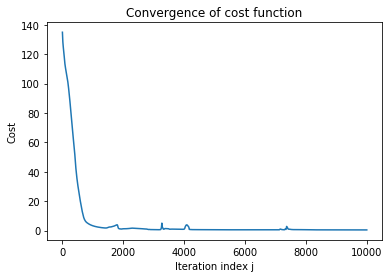

Siste verdien til J-funksjonen:  0.5033201934826111


In [42]:
d = 2  
h = 0.1

K = 15    #K har veldig mye å si på hvor fort J konvergerer
I = 1000   
iterations = 10000  #Kan økes til 40 000 for å få veldig liten J
chunk = I

Y_0, c = get_data_spiral_2d(I)
c = c[:,0]

my, omega, b_k, W_k, Y_Kk, J, Z, c = algorithm(Y_0, c, K, d, iterations, h, len(Y_0[0,:]), chunk)
write_to_file(my, omega, b_k, W_k, "parameters_points.txt")

print_successrate(Z,c, tol=0.05)
print("Siste verdien til J-funksjonen: ", J[-1])
plot_cost_function_convergence(iterations, J)

#Legger til celler under med tabellen av forskjellige verider som viser de optimaliserte verdiene

**Tester parameterene**

Ratio of correctly classified points: 0.989 (with tolerated difference between classification point and label: 0.05)
Plotter test resultatene


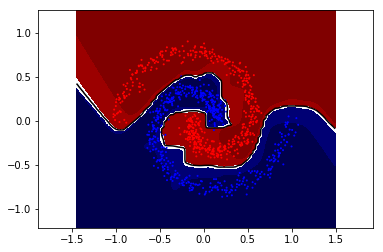

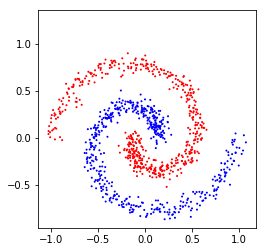

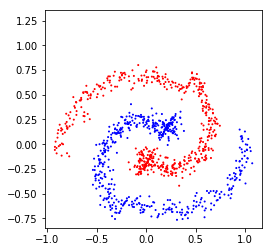

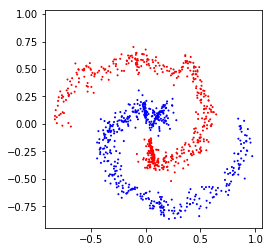

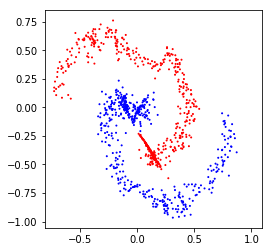

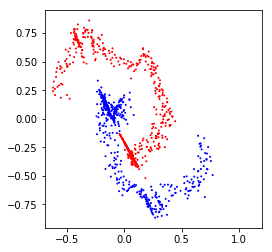

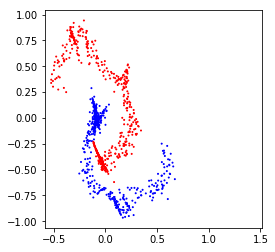

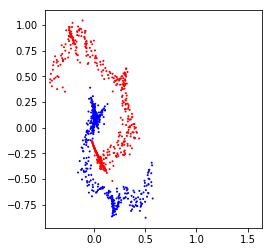

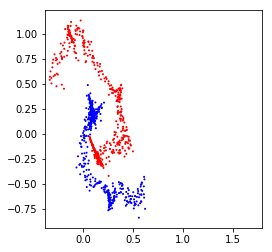

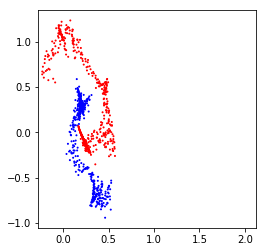

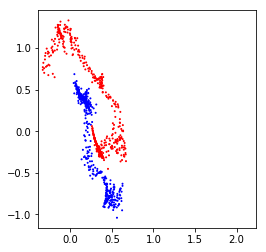

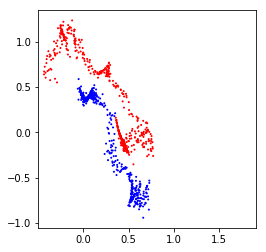

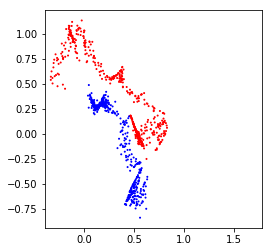

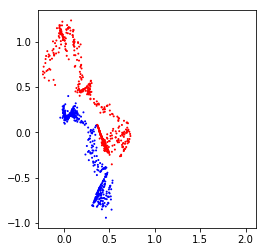

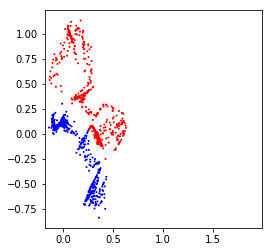

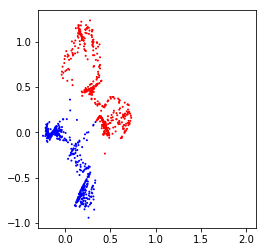

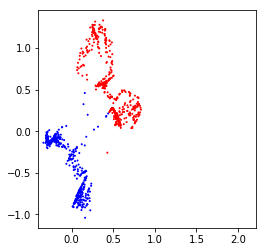

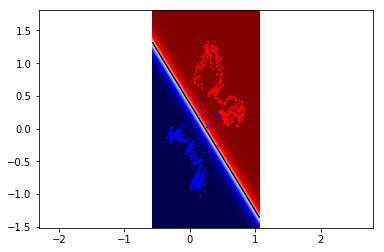

In [56]:
Y_0, c_test = get_data_spiral_2d(I)
Y_Kk_test, Z_test = test_parameters(Y_0, h, K, d, I, "parameters_points.txt")
print_successrate(Z_test, c_test, tol=0.05)

print("Plotter test resultatene")
plot_model(forward_function,Y_Kk_test[0,:,:],c_test,100)
plot_progression(Y_Kk_test, c_test)
plot_separation(last_function,Y_Kk_test[-1,:,:],c_test,100)
#Er det en mulighet for å fjerne aksene ved første og siste plottet?
#Kan vi skrive K=number for hver av plottene i plot_progression?

## MNIST - siffergjenkjenning

**Trener parameterene**

Training session: 
Ratio of correctly classified points: 0.965 (with tolerated difference between classification point and label: 0.05)


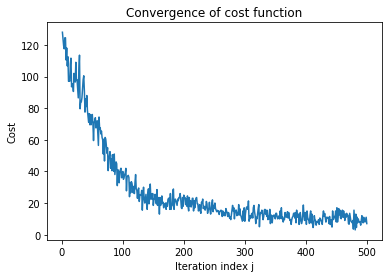

In [39]:
d = 784   #28x28
h = 0.1

K = 15            #ser ut som konvergensen nesten er helt uavh. av K. K=3 og K=18 gir omtrent det samme
chunk = 400       #kurven blir mye glattere med stor chunk
iterations = 500  #Konvergerer ish etter 400 iterasjoner
#Med stor chunk=400 og få iterations=500 får jeg 0.965 (K=15)
#Med liten chunk=128 og mange iterations=1000 får jeg

Y_0, c = get_dataset("training")  #784x1233
c = c[:,0]

my, omega, b_k, W_k, Y_Kk, J, Z, c  = algorithm(Y_0, c, K, d, iterations, h, len(Y_0[0,:]), chunk)
write_to_file(my, omega, b_k, W_k, "parameters_images.txt")

print_successrate(Z, c, tol=0.05)
print("Siste verdien til J-funksjonen: ", J[-1])
plot_cost_function_convergence(iterations, J)


#Legger til celler med tabeller av verdier av successrate for ulike parametere
#Endre tabellen-teksten til norsk

**Tester parameterene**

Ratio of correctly classified points: 0.93 (with tolerated difference between classification point and label: 0.05)
Første bildet i Y_0


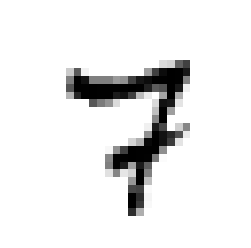

Første bildet i Y_k


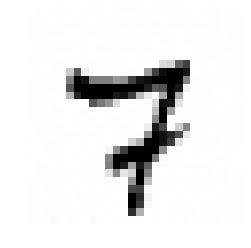

In [61]:
#Kan ha en passe stor chunk her?
chunk = 600

Y_0, c = get_dataset("testing") 
Y_0_test, c_test = stochastic_gradient_descent(Y_0, c, len(Y_0[0,:]), chunk)
Y_Kk_test, Z_test = test_parameters(Y_0_test, h, K, d, chunk, "parameters_images.txt")

print_successrate(Z_test,c_test, tol=0.05)


print("Første bildet i Y_0")
show_image(Y_0_test, 1)

print("Første bildet i Y_k")
show_image(Y_Kk_test[-1], 1)


Med samme parametere tester vi på to andre siffere; her 1 og 9.
Ratio of correctly classified points: 0.7166666666666667 (with tolerated difference between classification point and label: 0.05)
Første bildet i et tilfeldig utvalg av Y_0.


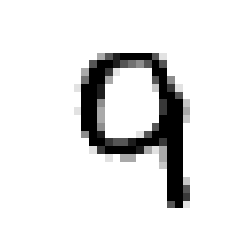

Samme bildet transformert 15 ganger.


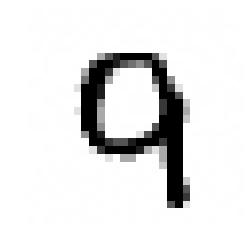

In [65]:
print("Med samme parametere tester vi på to andre siffere; her 1 og 9.")

chunk = 600
Y_0, c = get_dataset("testing", 1, 9) 
Y_0_test, c_test = stochastic_gradient_descent(Y_0, c, len(Y_0[0,:]), chunk)
Y_Kk_test, Z_test = test_parameters(Y_0_test, h, K, d, chunk, "parameters_images.txt")

print_successrate(Z_test,c_test, tol=0.05)


print("Første bildet i et tilfeldig utvalg av Y_0.")
show_image(Y_0_test, 1)

print("Samme bildet transformert", K, "ganger.")
show_image(Y_Kk_test[-1], 1)

In [ ]:
#Legg til tekst om hvordan bildene ikke endrer seg som i punkter i planet
#Legg til sammenligning av andre to andre siffere?